<ipython-input-2-ce2ca0026c79>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time']).astype(int) / 10**9  # Convert to timestamp in seconds


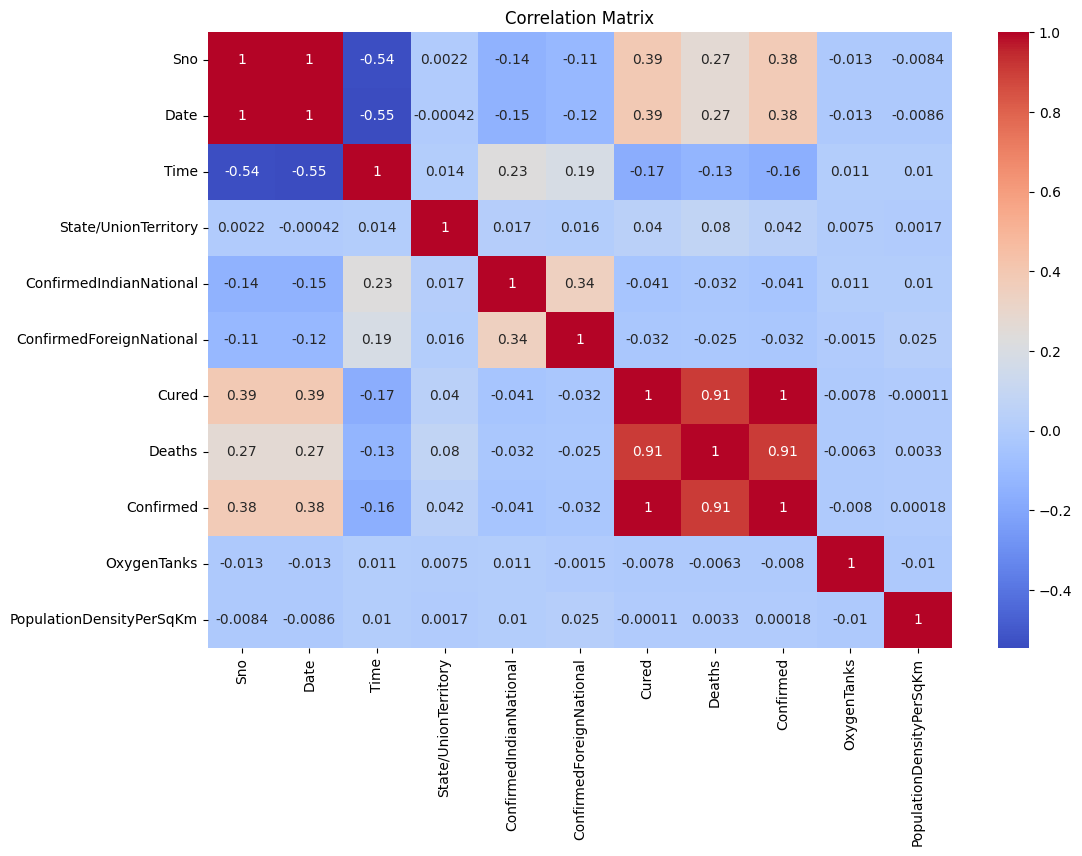

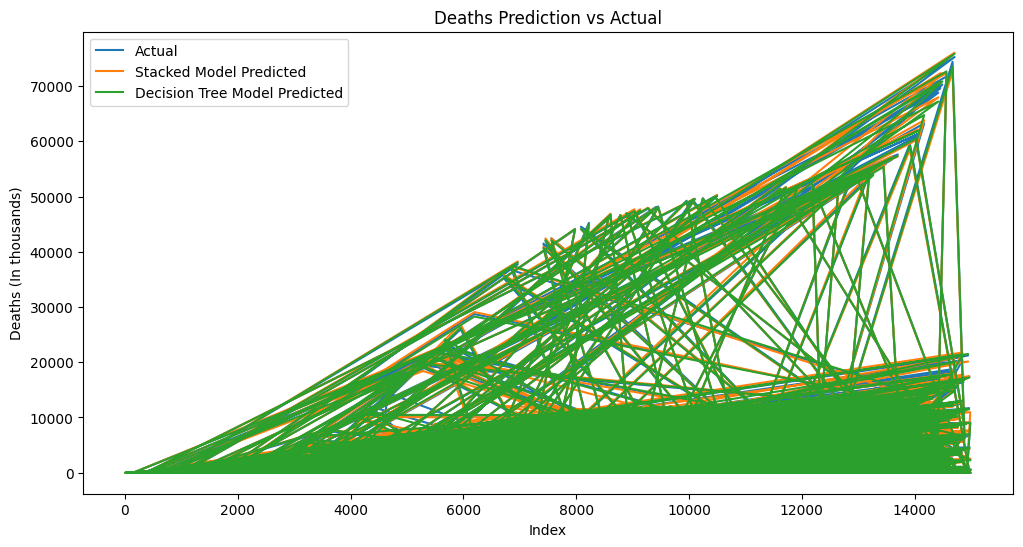

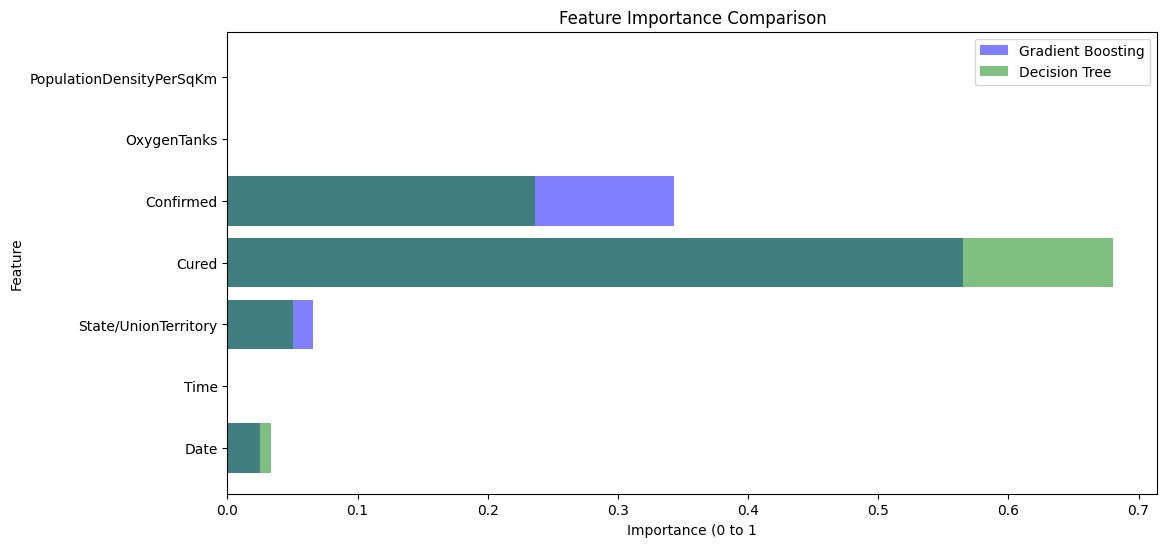

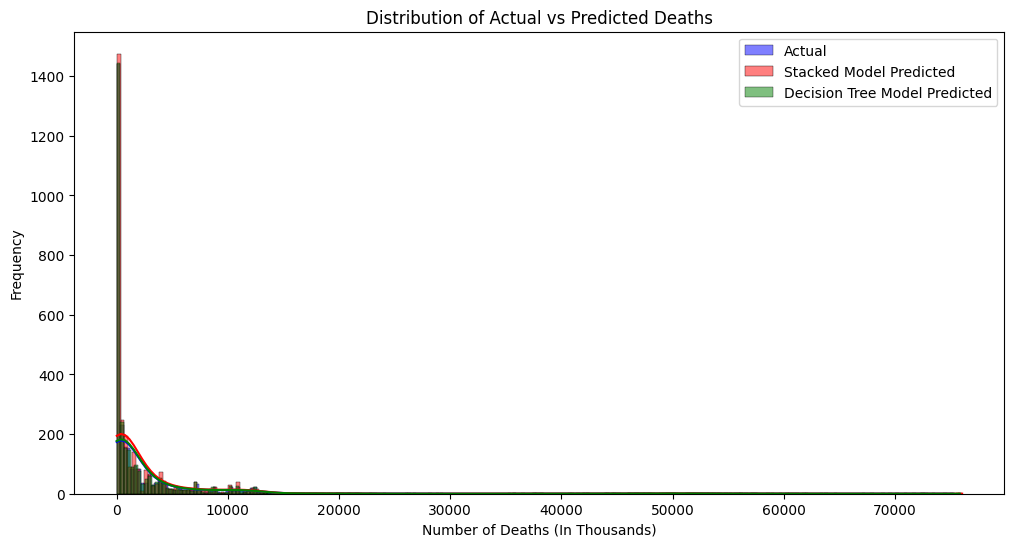

Decision Tree Model Performance:
Mean Absolute Error (MAE): 37.947684105298656
Mean Squared Error (MSE): 46332.037654115295
Root Mean Squared Error (RMSE): 215.24878084234368
R² Score: 0.9991421940777198

Stacked Model Performance:
Mean Absolute Error (MAE): 81.16069137880517
Mean Squared Error (MSE): 92133.44306380051
Root Mean Squared Error (RMSE): 303.53491242985626
R² Score: 0.9982942124477624

Preprocessing steps:
- Replaced non-numeric values with NaN and handled missing values
- Encoded categorical features using LabelEncoder
- Converted Date and Time features to timestamp in seconds
- Split the data into training and testing sets
- Normalized the features using StandardScaler
Predictions saved to 'predicted_deaths.csv'


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset
df = pd.read_csv("/content/train_data_covid.csv")

# Replace non-numeric values with NaN and handle missing values
df.replace('-', np.nan, inplace=True)
df.fillna(0, inplace=True)

# Preprocessing
label_encode = LabelEncoder()
df['State/UnionTerritory'] = label_encode.fit_transform(df['State/UnionTerritory'])
df['Date'] = pd.to_datetime(df['Date']).astype(int) / 10**9  # Convert to timestamp in seconds
df['Time'] = pd.to_datetime(df['Time']).astype(int) / 10**9  # Convert to timestamp in seconds

# Split the data into features and target
x = df.drop(['Sno', 'Deaths', 'ConfirmedIndianNational', 'ConfirmedForeignNational'], axis=1)
y = df['Deaths']

# Plot correlation matrix for the preprocessed data
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Split the preprocessed data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=32)

# Normalize the data with StandardScaler
scaler_x = StandardScaler()
scaler_y = StandardScaler()
x_train_scaled = scaler_x.fit_transform(x_train)
x_test_scaled = scaler_x.transform(x_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Define the base models
base_models = [
    ('decision_tree', DecisionTreeRegressor(random_state=23)),
    ('gradient_boosting', GradientBoostingRegressor(random_state=23))
]

# Define a Decision Tree model separately for comparison
decision_tree_model = DecisionTreeRegressor(random_state=23)
decision_tree_model.fit(x_train_scaled, y_train_scaled.ravel())

# Fit the stacked model
stacked_model = StackingRegressor(estimators=base_models, final_estimator=GradientBoostingRegressor(random_state=23))
stacked_model.fit(x_train_scaled, y_train_scaled.ravel())

# Make predictions on the test set for the Decision Tree model
dt_predictions = decision_tree_model.predict(x_test_scaled)
dt_predictions_inverse = scaler_y.inverse_transform(dt_predictions.reshape(-1, 1))

# Evaluate Decision Tree model performance
dt_mae = mean_absolute_error(y_test, dt_predictions_inverse)
dt_mse = mean_squared_error(y_test, dt_predictions_inverse)
dt_rmse = np.sqrt(dt_mse)
dt_r2 = r2_score(y_test, dt_predictions_inverse)

# Make predictions on the test set for the stacked model
predictions = stacked_model.predict(x_test_scaled)
predictions_inverse = scaler_y.inverse_transform(predictions.reshape(-1, 1))

# Evaluate stacked model performance
mae = mean_absolute_error(y_test, predictions_inverse)
mse = mean_squared_error(y_test, predictions_inverse)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions_inverse)

# Plot predictions vs actual for both models
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, predictions_inverse, label='Stacked Model Predicted')
plt.plot(y_test.index, dt_predictions_inverse, label='Decision Tree Model Predicted')
plt.title('Deaths Prediction vs Actual')
plt.xlabel('Index (s.no)')
plt.ylabel('Deaths (In thousands)')
plt.legend()
plt.show()

# Feature names
features = x.columns

# Plot feature importance comparison between Gradient Boosting and Decision Tree models
plt.figure(figsize=(12, 6))
# Ensure that both models have feature importances of the same length as the number of features
gb_importances = base_models[1][1].fit(x_train_scaled, y_train_scaled.ravel()).feature_importances_
dt_importances = decision_tree_model.feature_importances_

plt.barh(features, gb_importances, color='blue', alpha=0.5, label='Gradient Boosting')
plt.barh(features, dt_importances, color='green', alpha=0.5, label='Decision Tree')
plt.title('Feature Importance Comparison')
plt.xlabel('Importance (0 to 1)')
plt.ylabel('Feature')
plt.legend()
plt.show()

# Plot distribution of actual vs predicted deaths
plt.figure(figsize=(12, 6))
sns.histplot(y_test, color='blue', label='Actual', kde=True, alpha=0.5)
sns.histplot(predictions_inverse.flatten(), color='red', label='Stacked Model Predicted', kde=True, alpha=0.5)
sns.histplot(dt_predictions_inverse.flatten(), color='green', label='Decision Tree Model Predicted', kde=True, alpha=0.5)
plt.title('Distribution of Actual vs Predicted Deaths')
plt.xlabel('Number of Deaths (In Thousands)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Print evaluation metrics for both models
print("Decision Tree Model Performance:")
print("Mean Absolute Error (MAE):", dt_mae)
print("Mean Squared Error (MSE):", dt_mse)
print("Root Mean Squared Error (RMSE):", dt_rmse)
print("R² Score:", dt_r2)

print("\nStacked Model Performance:")
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score:", r2)

# Print preprocessing steps
print("\nPreprocessing steps:")
print("- Replaced non-numeric values with NaN and handled missing values")
print("- Encoded categorical features using LabelEncoder")
print("- Converted Date and Time features to timestamp in seconds")
print("- Split the data into training and testing sets")
print("- Normalized the features using StandardScaler")

# Preprocess the test data for predictions
test_df = pd.read_csv("/content/test_data_covid.csv")

# Replace specific state names in the test data
test_df['State/UnionTerritory'] = test_df['State/UnionTerritory'].replace({
    'Madhya Pradesh***': 'Madhya Pradesh',
    'Himanchal Pradesh': 'Himachal Pradesh',
    'Karanataka': 'Karnataka',
    'Maharashtra***': 'Maharashtra',
    'Dadra and Nagar Haveli': 'Goa',
    'Bihar****': 'Bihar'
})

# Replace non-numeric values with NaN and handle missing values in the test data
test_df.replace('-', np.nan, inplace=True)
test_df.fillna(0, inplace=True)

# Apply label encoding using the fitted LabelEncoder from training data
test_df['State/UnionTerritory'] = label_encode.transform(test_df['State/UnionTerritory'])
test_df['Date'] = pd.to_datetime(test_df['Date']).astype(int) / 10**9  # Convert to timestamp in seconds
test_df['Time'] = pd.to_datetime(test_df['Time']).astype(int) / 10**9  # Convert to timestamp in seconds
x_test_final = test_df.drop(['Sno', 'ConfirmedIndianNational', 'ConfirmedForeignNational'], axis=1)
x_test_final_scaled = scaler_x.transform(x_test_final)

# Make final predictions
final_predictions = stacked_model.predict(x_test_final_scaled)
final_predictions_inverse = scaler_y.inverse_transform(final_predictions.reshape(-1, 1))

# Save the predictions to a CSV file
predictions_df = pd.DataFrame({
    'Sno': test_df['Sno'],
    'Predicted_Deaths': final_predictions_inverse.flatten()
})
predictions_df.to_csv('/content/predicted_deaths.csv', index=False)
print("Predictions saved to 'predicted_deaths.csv'")

Predictions saved to 'predicted_deaths.csv'
